In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm
from sklearn.linear_model import RidgeCV

# Set colours for plots
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

In [ ]:
# TODO: EDA
# TODO: get regression coefficients
# TODO: Check why causal graph doesn't match ground truth
# TODO: Add markdown commentary

In [2]:
def plot_graph(input_graph, node_lookup):
    '''
    Function to visualise graphs.

    Args:
        input_graph (array): Adjacency matrix representing graph
        node_lookup (dict): Dictionary containing node names.
    '''
    
    graph = nx.DiGraph(input_graph)

    plt.figure(figsize=(8,8))
    nx.draw(
    G=graph,
    node_color=COLORS[0],
    node_size=8000,
    arrowsize=17,
    with_labels=True,
    labels=node_lookup,
    font_color='white',
    font_size=9,
    pos=nx.circular_layout(graph)
    )

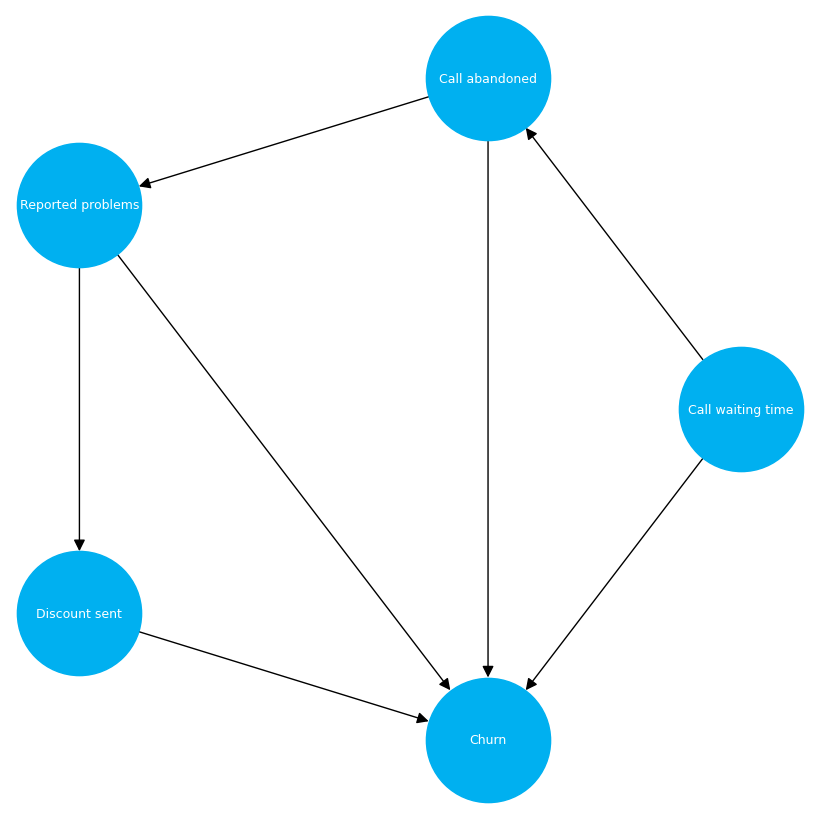

In [3]:
# Create node lookup for channels
node_lookup = {0: 'Call waiting time',
    1: 'Call abandoned', 
    2: 'Reported problems',                   
    3: 'Discount sent',
    4: 'Churn'                                                                             
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the basis for our known graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create known graph using expert domain knowledge
graph_actual[0, 1] = 1.0 # Call waiting time -> Call abandoned
graph_actual[0, 4] = 1.0 # Call waiting time -> Churn
graph_actual[1, 2] = 1.0 # Call abandoned -> Reported problems
graph_actual[1, 4] = 1.0 # Call abandoned -> Churn
graph_actual[2, 3] = 1.0 # Reported problems -> Discount sent
graph_actual[2, 4] = 1.0 # Reported problems -> Churn
graph_actual[3, 4] = 1.0 # Discount sent -> Churn
     
plot_graph(input_graph=graph_actual, node_lookup=node_lookup)

In [4]:
def data_generator(max_call_waiting, inbound_calls, call_reduction):
    '''
     A data generating function which has the flexibility to reduce the value of node 0 (Call waiting time) - this enables us to calculate ground truth counterfactuals

    Args:
        max_call_waiting (int): Maximum call waiting time in seconds
        inbound_calls (int): Total number of inbound calls (observations in data)
        call_reduction (float): Reduction to apply to call waiting time

    Returns:
        DataFrame: Generated data
    '''
    
    df = pd.DataFrame(columns=node_lookup.values())

    # Call waiting time
    df[node_lookup[0]] = np.random.randint(low=10, high=max_call_waiting, size=(inbound_calls)) * (call_reduction)

    # Call abandoned
    node_normalised_0 = df[node_lookup[0]] / max_call_waiting
    df[node_lookup[1]] = np.random.binomial(1, p=node_normalised_0)

    # Reported problems
    df[node_lookup[2]] = np.random.randint(low=1, high=5, size=(inbound_calls)) * (1 - df[node_lookup[1]])

    # Discount sent
    node_normalised_3 = df[node_lookup[2]] / max(df[node_lookup[2]])
    df[node_lookup[3]] = np.random.binomial(1, p=node_normalised_3)

    # Churn
    node_4 = (0.10 * node_normalised_0) + (0.30 * df[node_lookup[1]]) + (0.15 * df[node_lookup[2]]) + (-0.20 * df[node_lookup[3]]) 
    node_4 = node_4.clip(lower=0)
    df[node_lookup[4]] = np.random.binomial(1, p=node_4)

    return df

In [5]:
# Set random seed
np.random.seed(999)

df = data_generator(max_call_waiting=600, inbound_calls=10000, call_reduction=1.00)
df

,Call waiting time,Call abandoned,Reported problems,Discount sent,Churn
0,458.0,1,0,0,0
1,358.0,1,0,0,1
2,491.0,1,0,0,0
3,235.0,0,3,1,1
4,485.0,0,1,1,0
...,...,...,...,...,...
9995,376.0,0,4,1,1
9996,25.0,0,1,0,0
9997,420.0,0,3,1,1
9998,292.0,1,0,0,0


In [6]:
# Set random seed
np.random.seed(999)

df_cf = data_generator(max_call_waiting=600, inbound_calls=10000, call_reduction=0.80)
df_cf

,Call waiting time,Call abandoned,Reported problems,Discount sent,Churn
0,366.4,1,0,0,0
1,286.4,0,4,1,1
2,392.8,0,4,1,0
3,188.0,0,3,1,1
4,388.0,0,1,1,0
...,...,...,...,...,...
9995,300.8,0,4,1,1
9996,20.0,0,1,0,0
9997,336.0,0,3,1,1
9998,233.6,1,0,0,0


<Axes: ylabel='Frequency'>

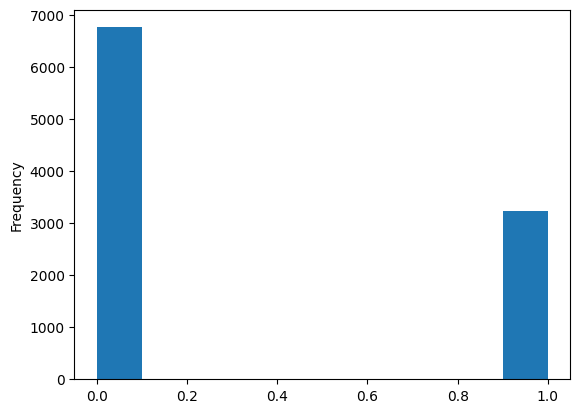

In [7]:
df['Churn'].plot.hist()

In [101]:
# Setup graph
graph = nx.from_numpy_array(graph_actual, create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, node_lookup)

# Create SCM
causal_model = gcm.InvertibleStructuralCausalModel(graph)
causal_model.set_causal_mechanism('Call waiting time', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('Call abandoned', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor()))
causal_model.set_causal_mechanism('Reported problems', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor()))
causal_model.set_causal_mechanism('Discount sent', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor()))
causal_model.set_causal_mechanism('Churn', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor()))
gcm.fit(causal_model, df)

Fitting causal mechanism of node Churn: 100%|██████████| 5/5 [00:00<00:00, 162.77it/s]   


Test permutations of given graph: 100%|██████████| 50/50 [00:04<00:00, 10.60it/s]


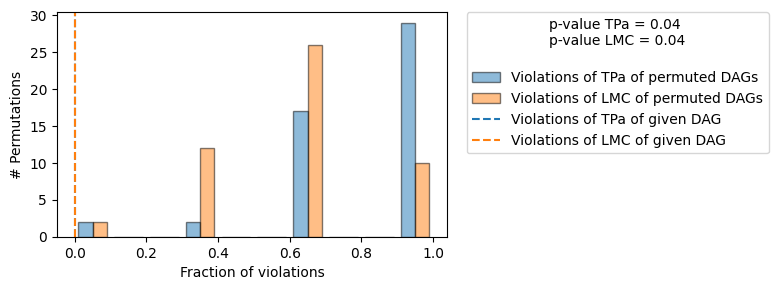

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [35]:
# Check model fit statistics
print(gcm.evaluate_causal_model(causal_model, df))

In [104]:
# Linear regression
y = df['Churn'].copy()
X = df.iloc[:, 0:-1].copy()
model = RidgeCV()
model = model.fit(X, y)
y_pred = model.predict(X)

print(f'Intercept: {model.intercept_}')
print(f'Coefficient: {model.coef_}')

Intercept: 0.022026712991178532
Coefficient: [ 1.39242264e-04  2.91943072e-01  1.40715135e-01 -2.00303315e-01]


In [137]:
# Ground truth - What would have happened if we had decreased the Call waiting time by 20%
round((df['Churn'].sum() - df_cf['Churn'].sum()) / df['Churn'].sum(), 2)

In [138]:
# Causal graph - What would have happened if we had decreased the Call waiting time by 20%
df_counterfactual = gcm.counterfactual_samples(causal_model, {'Call waiting time': lambda x: x*0.8}, observed_data=df)
round((df['Churn'].sum() - df_counterfactual['Churn'].sum()) / (df['Churn'].sum()), 3)

In [139]:
# Linear regression - What would have happened if we had decreased the Call waiting time by 20%?
round((df['Call waiting time'].sum() * 1.0 * model.coef_[0] - df['Call waiting time'].sum() * 0.8 * model.coef_[0]) / (df['Churn'].sum()), 3)